# Unit 16: CNN 卷積神經網路實作演練
## 使用 MNIST 手寫數字辨識資料集

---

## 學習目標
- 學習如何載入和預處理 MNIST 資料集
- 學習如何使用 Keras 建立 CNN 模型
- 學習如何訓練、評估和使用 CNN 模型進行預測
- 學習如何視覺化訓練過程和預測結果
- 學習如何保存和載入訓練好的模型

---

## 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P4_Unit16_Results'
SOURCE_DATA_DIR = ''

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_4'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")


# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_4
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_4\data
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Results
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Results\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Results\figs

TensorFlow Version: 2.10.0
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


---
## 1. 導入必要的套件

In [19]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import joblib, pickle, json
import warnings
warnings.filterwarnings('ignore')

# sklearn套件
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

print(f"TensorFlow版本: {tf.__version__}")
print(f"Keras版本: {keras.__version__}")

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(seed=None)
tf.random.set_seed(seed=None)

# 設定matplotlib中文顯示
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial'] # Colab不支援
plt.rcParams['axes.unicode_minus'] = False

TensorFlow版本: 2.10.0
Keras版本: 2.10.0


## 2. 載入 MNIST 資料集

MNIST 資料集包含 70,000 張手寫數字影像 (0-9):
- 訓練集: 60,000 張
- 測試集: 10,000 張
- 影像尺寸: 28×28 像素
- 灰階影像: 像素值範圍 0-255

In [3]:
# 載入 MNIST 資料集
print("正在載入 MNIST 資料集...")
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("\n資料集載入完成!")
print(f"訓練集影像形狀: {x_train.shape}")
print(f"訓練集Label形狀: {y_train.shape}")
print(f"測試集影像形狀: {x_test.shape}")
print(f"測試集Label形狀: {y_test.shape}")

正在載入 MNIST 資料集...

資料集載入完成!
訓練集影像形狀: (60000, 28, 28)
訓練集Label形狀: (60000,)
測試集影像形狀: (10000, 28, 28)
測試集Label形狀: (10000,)


## 3. 資料探索與視覺化

In [4]:
# 查看資料基本統計資訊
print("訓練集影像統計資訊:")
print(f"最小值: {x_train.min()}")
print(f"最大值: {x_train.max()}")
print(f"平均值: {x_train.mean():.2f}")
print(f"標準差: {x_train.std():.2f}")

# 查看Label分布
print("\nTraining Set Label Distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for digit, count in zip(unique, counts):
    print(f"Digit {digit}: {count} 張 ({count/len(y_train)*100:.2f}%)")

訓練集影像統計資訊:
最小值: 0
最大值: 255
平均值: 33.32
標準差: 78.57

Training Set Label Distribution:
Digit 0: 5923 張 (9.87%)
Digit 1: 6742 張 (11.24%)
Digit 2: 5958 張 (9.93%)
Digit 3: 6131 張 (10.22%)
Digit 4: 5842 張 (9.74%)
Digit 5: 5421 張 (9.04%)
Digit 6: 5918 張 (9.86%)
Digit 7: 6265 張 (10.44%)
Digit 8: 5851 張 (9.75%)
Digit 9: 5949 張 (9.92%)


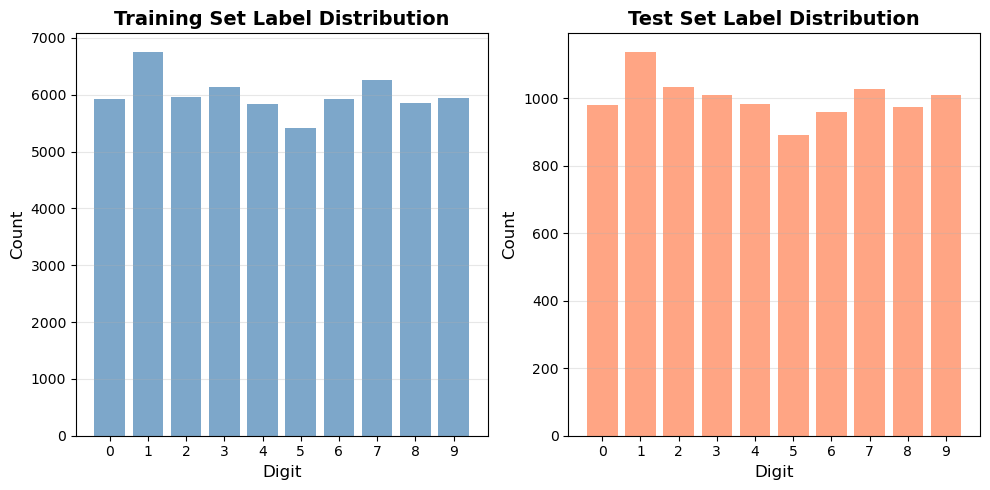

In [6]:
# 視覺化Label分布
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(unique, counts, color='steelblue', alpha=0.7)
plt.xlabel('Digit', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Training Set Label Distribution', fontsize=14, fontweight='bold')
plt.xticks(unique)
plt.grid(axis='y', alpha=0.3)

# Test Set Label Distribution
unique_test, counts_test = np.unique(y_test, return_counts=True)
plt.subplot(1, 2, 2)
plt.bar(unique_test, counts_test, color='coral', alpha=0.7)
plt.xlabel('Digit', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Test Set Label Distribution', fontsize=14, fontweight='bold')
plt.xticks(unique_test)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'label_distribution.png')
plt.show()

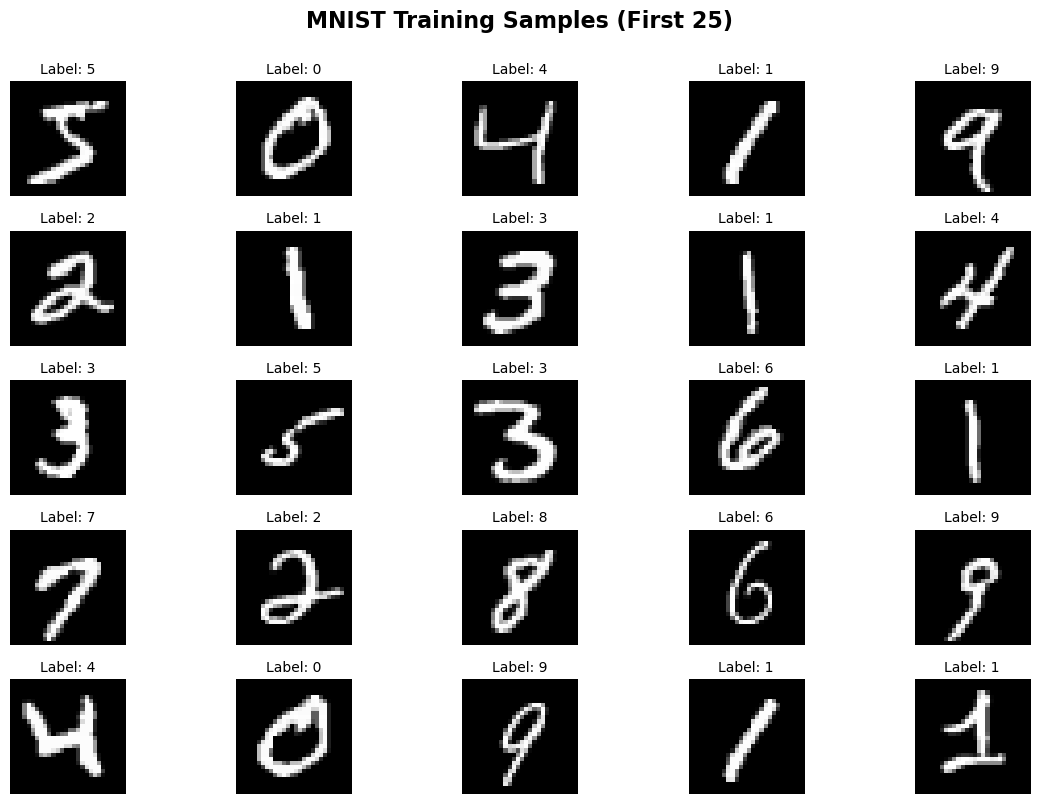

In [8]:
# 視覺化部分訓練樣本
plt.figure(figsize=(12, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}', fontsize=10)
    plt.axis('off')

plt.suptitle('MNIST Training Samples (First 25)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(FIG_DIR / 'mnist_training_samples.png')
plt.show()

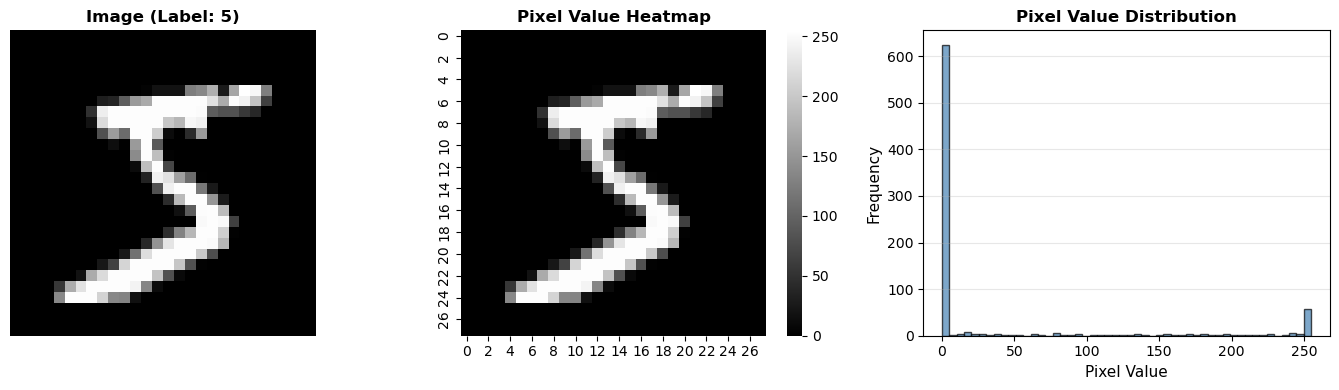

In [11]:
# 視覺化單一影像的Pixel Value分布
sample_idx = 0
sample_image = x_train[sample_idx]
sample_label = y_train[sample_idx]

plt.figure(figsize=(14, 4))

# 顯示影像
plt.subplot(1, 3, 1)
plt.imshow(sample_image, cmap='gray')
plt.title(f'Image (Label: {sample_label})', fontsize=12, fontweight='bold')
plt.axis('off')

# 顯示Pixel Value Heatmap
plt.subplot(1, 3, 2)
sns.heatmap(sample_image, cmap='gray', cbar=True, square=True)
plt.title('Pixel Value Heatmap', fontsize=12, fontweight='bold')

# 顯示Pixel Value分布直方圖
plt.subplot(1, 3, 3)
plt.hist(sample_image.flatten(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('Pixel Value', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Pixel Value Distribution', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'image_distribution.png')
plt.show()

---
## 4. 資料預處理

### 4.1 正規化 (Normalization)
將像素值從 [0, 255] 縮放到 [0, 1],有助於模型訓練。

### 4.2 重塑 (Reshape)
CNN 需要 4D 輸入: (樣本數, 高度, 寬度, 通道數)
- MNIST 是灰階影像,通道數為 1

In [12]:
# 正規化: 將Pixel Value縮放到 [0, 1]
x_train_normalized = x_train.astype('float32') / 255.0
x_test_normalized = x_test.astype('float32') / 255.0

print("正規化後的統計資訊:")
print(f"訓練集 - 最小值: {x_train_normalized.min()}, 最大值: {x_train_normalized.max()}")
print(f"測試集 - 最小值: {x_test_normalized.min()}, 最大值: {x_test_normalized.max()}")

正規化後的統計資訊:
訓練集 - 最小值: 0.0, 最大值: 1.0
測試集 - 最小值: 0.0, 最大值: 1.0


In [13]:
# 重塑: 添加通道維度
x_train_reshaped = x_train_normalized.reshape(-1, 28, 28, 1)
x_test_reshaped = x_test_normalized.reshape(-1, 28, 28, 1)

print("重塑後的形狀:")
print(f"訓練集: {x_train_reshaped.shape}")
print(f"測試集: {x_test_reshaped.shape}")

重塑後的形狀:
訓練集: (60000, 28, 28, 1)
測試集: (10000, 28, 28, 1)


In [14]:
# 查看Label的唯一值
print(f"\nLabel的唯一值: {np.unique(y_train)}")
print(f"類別Count: {len(np.unique(y_train))}")

# 注意: 我們使用 sparse_categorical_crossentropy,所以不需要 one-hot 編碼
# 如果使用 categorical_crossentropy,則需要進行 one-hot 編碼:
# y_train_onehot = to_categorical(y_train, num_classes=10)
# y_test_onehot = to_categorical(y_test, num_classes=10)


Label的唯一值: [0 1 2 3 4 5 6 7 8 9]
類別Count: 10


---
## 5. 建立 CNN 模型

### 模型架構:
1. **卷積塊 1**: Conv2D(32) → MaxPooling2D
2. **卷積塊 2**: Conv2D(64) → MaxPooling2D
3. **卷積塊 3**: Conv2D(64)
4. **全連接層**: Flatten → Dense(64) → Dropout(0.5) → Dense(10)

In [ ]:
# 使用 Sequential API 建立模型
model = Sequential([
    # 第一個卷積塊
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                    input_shape=(28, 28, 1), padding='same', name='conv1'),
    MaxPooling2D(pool_size=(2, 2), name='pool1'),
    
    # 第二個卷積塊
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
                    padding='same', name='conv2'),
    MaxPooling2D(pool_size=(2, 2), name='pool2'),
    
    # 第三個卷積塊
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
                    padding='same', name='conv3'),
    
    # 展平層
    Flatten(name='flatten'),
    
    # 全連接層
    Dense(units=64, activation='relu', name='dense1'),
    Dropout(rate=0.5, name='dropout'),
    
    # 輸出層 (10 個類別)
    Dense(units=10, activation='softmax', name='output')
], name='MNIST_CNN')
print("CNN 模型建立完成!")


# 查看模型結構
model.summary()


CNN 模型建立完成!
Model: "MNIST_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 28, 28, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 7, 7, 64)          0         
                                                                 
 conv3 (Conv2D)              (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense1 (Dense)              (None, 64)      

### 模型參數計算說明:

**Conv2D 層的參數數量計算:**
- 公式: `參數數量 = (kernel_height × kernel_width × input_channels + 1) × filters`
- `+1` 是偏差項 (bias)

**範例 - conv1 層:**
- kernel_size = (3, 3)
- input_channels = 1 (灰階影像)
- filters = 32
- 參數數量 = (3 × 3 × 1 + 1) × 32 = 10 × 32 = 320

**Dense 層的參數數量計算:**
- 公式: `參數數量 = (input_units + 1) × output_units`

**範例 - dense1 層:**
- input_units = 3136 (來自 Flatten 層)
- output_units = 64
- 參數數量 = (3136 + 1) × 64 = 200,768

---
## 6. 編譯模型

### 編譯參數說明:
- **optimizer**: Adam (自適應學習率優化器)
- **loss**: sparse_categorical_crossentropy (多類別分類,標籤為整數)
- **metrics**: accuracy (準確率)

In [21]:
# 編譯模型
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("模型編譯完成!")
print(f"優化器: Adam")
print(f"損失函數: Sparse Categorical Crossentropy")
print(f"評估指標: Accuracy")

模型編譯完成!
優化器: Adam
損失函數: Sparse Categorical Crossentropy
評估指標: Accuracy


---
## 7. 設定 Callbacks

### Callbacks 說明:
1. **EarlyStopping**: 當驗證損失不再改善時,提前停止訓練
2. **ModelCheckpoint**: 保存訓練過程中的最佳模型
3. **ReduceLROnPlateau**: 當驗證損失停止改善時,降低學習率

In [ ]:
# 設定 Callbacks
callbacks_list = [
    # Early Stopping: 當Validation Loss連續 5 個 epochs 沒有改善時停止訓練
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Model Checkpoint: 保存最佳模型
    ModelCheckpoint(
        filepath=MODEL_DIR / 'best_mnist_cnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    
    # Reduce Learning Rate: 當Validation Loss連續 3 個 epochs 沒有改善時,將學習率降低為原來的 0.5 倍
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks 設定完成!")

Callbacks 設定完成!


---
## 8. 訓練模型

### 訓練參數:
- **epochs**: 20 (最大訓練輪數)
- **batch_size**: 128
- **validation_split**: 0.2 (從訓練集中分出 20% 作為驗證集)

In [23]:
# 訓練模型
print("開始訓練模型...\n")

history = model.fit(
    x_train_reshaped, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=callbacks_list,
    verbose=1
)

print("\n模型訓練完成!")

開始訓練模型...

Epoch 1/20
370/375 [============================>.] - ETA: 0s - loss: 0.3989 - accuracy: 0.8754
Epoch 1: val_accuracy improved from -inf to 0.97792, saving model to best_mnist_cnn_model.h5
375/375 [==============================] - 4s 6ms/step - loss: 0.3956 - accuracy: 0.8765 - val_loss: 0.0739 - val_accuracy: 0.9779 - lr: 0.0010
Epoch 2/20
364/375 [============================>.] - ETA: 0s - loss: 0.1272 - accuracy: 0.9640
Epoch 2: val_accuracy improved from 0.97792 to 0.98700, saving model to best_mnist_cnn_model.h5
375/375 [==============================] - 2s 5ms/step - loss: 0.1266 - accuracy: 0.9641 - val_loss: 0.0454 - val_accuracy: 0.9870 - lr: 0.0010
Epoch 3/20
370/375 [============================>.] - ETA: 0s - loss: 0.0860 - accuracy: 0.9758
Epoch 3: val_accuracy improved from 0.98700 to 0.98875, saving model to best_mnist_cnn_model.h5
375/375 [==============================] - 2s 5ms/step - loss: 0.0862 - accuracy: 0.9758 - val_loss: 0.0399 - val_accuracy: 0.98

---
## 9. 視覺化訓練歷史

### 訓練曲線分析:
- **損失曲線**: 觀察訓練損失和驗證損失的變化
- **準確率曲線**: 觀察訓練準確率和驗證準確率的變化
- **過擬合診斷**: 如果訓練損失持續下降但驗證損失上升,表示過擬合

In [24]:
# 提取訓練歷史
history_dict = history.history

# 查看可用的指標
print("可用的訓練指標:")
for key in history_dict.keys():
    print(f"  - {key}")

可用的訓練指標:
  - loss
  - accuracy
  - val_loss
  - val_accuracy
  - lr


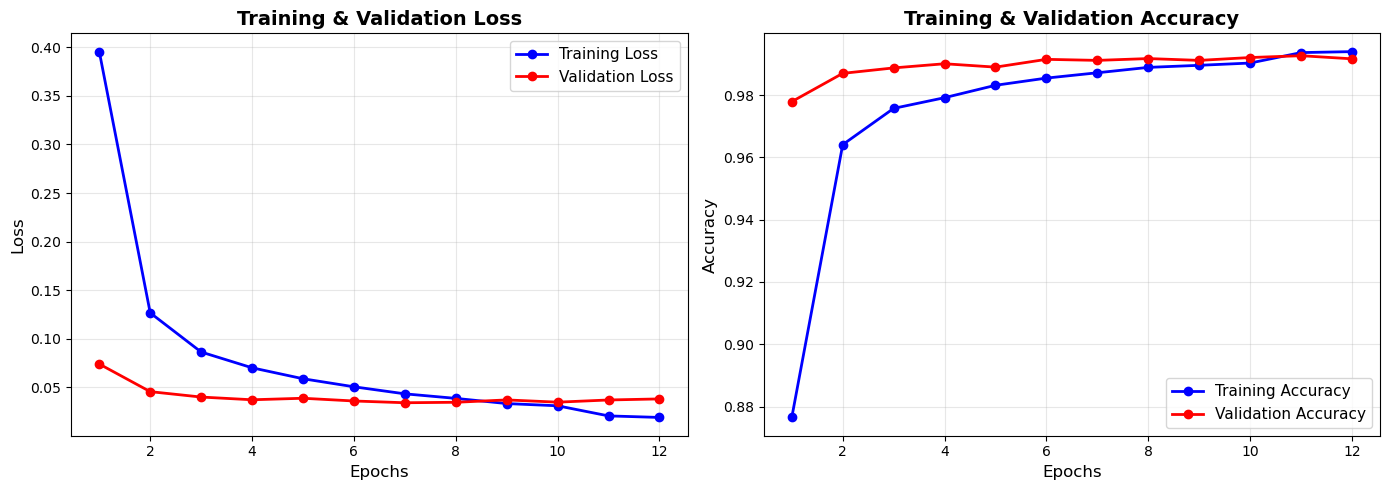


訓練結果摘要:
最終Training Loss: 0.0189
最終Validation Loss: 0.0379
最終Training Accuracy: 0.9940
最終Validation Accuracy: 0.9917

最佳Validation Accuracy: 0.9927 (Epoch 11)


In [25]:
# 繪製訓練歷史
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(14, 5))

# 損失曲線
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss', linewidth=2, markersize=6)
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training & Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# 準確率曲線
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
plt.plot(epochs_range, val_accuracy, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'training_history.png')
plt.show()

# 顯示最終結果
print("\n訓練結果摘要:")
print(f"最終Training Loss: {loss[-1]:.4f}")
print(f"最終Validation Loss: {val_loss[-1]:.4f}")
print(f"最終Training Accuracy: {accuracy[-1]:.4f}")
print(f"最終Validation Accuracy: {val_accuracy[-1]:.4f}")
print(f"\n最佳Validation Accuracy: {max(val_accuracy):.4f} (Epoch {val_accuracy.index(max(val_accuracy)) + 1})")


---
## 10. 模型評估

### 在測試集上評估模型性能

In [26]:
# 在測試集上評估模型
print("在測試集上評估模型...\n")
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=1)

print(f"\n測試集損失: {test_loss:.4f}")
print(f"測試集準確率: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

在測試集上評估模型...

313/313 [==============================] - 1s 3ms/step - loss: 0.0291 - accuracy: 0.9916

測試集損失: 0.0291
測試集準確率: 0.9916 (99.16%)


---
## 11. 模型預測

### 使用訓練好的模型對測試集進行預測

In [27]:
# 對測試集進行預測
print("對測試集進行預測...")
y_pred_proba = model.predict(x_test_reshaped, verbose=0)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

print(f"預測完成! 預測結果形狀: {y_pred_proba.shape}")
print(f"Predicted Class形狀: {y_pred_classes.shape}")

對測試集進行預測...
預測完成! 預測結果形狀: (10000, 10)
Predicted Class形狀: (10000,)


In [28]:
# 查看單一樣本的預測結果
sample_idx = 0
sample_pred_proba = y_pred_proba[sample_idx]
sample_pred_class = y_pred_classes[sample_idx]
sample_true_class = y_test[sample_idx]

print(f"樣本 {sample_idx} 的預測結果:")
print(f"真實Label: {sample_true_class}")
print(f"預測Label: {sample_pred_class}")
print(f"預測Conf: {sample_pred_proba[sample_pred_class]:.4f}")
print(f"\n各類別的Prediction Probability:")
for i, prob in enumerate(sample_pred_proba):
    print(f"  Digit {i}: {prob:.4f}")

樣本 0 的預測結果:
真實Label: 7
預測Label: 7
預測Conf: 1.0000

各類別的Prediction Probability:
  Digit 0: 0.0000
  Digit 1: 0.0000
  Digit 2: 0.0000
  Digit 3: 0.0000
  Digit 4: 0.0000
  Digit 5: 0.0000
  Digit 6: 0.0000
  Digit 7: 1.0000
  Digit 8: 0.0000
  Digit 9: 0.0000


---
## 12. 詳細評估 - 混淆矩陣與分類報告

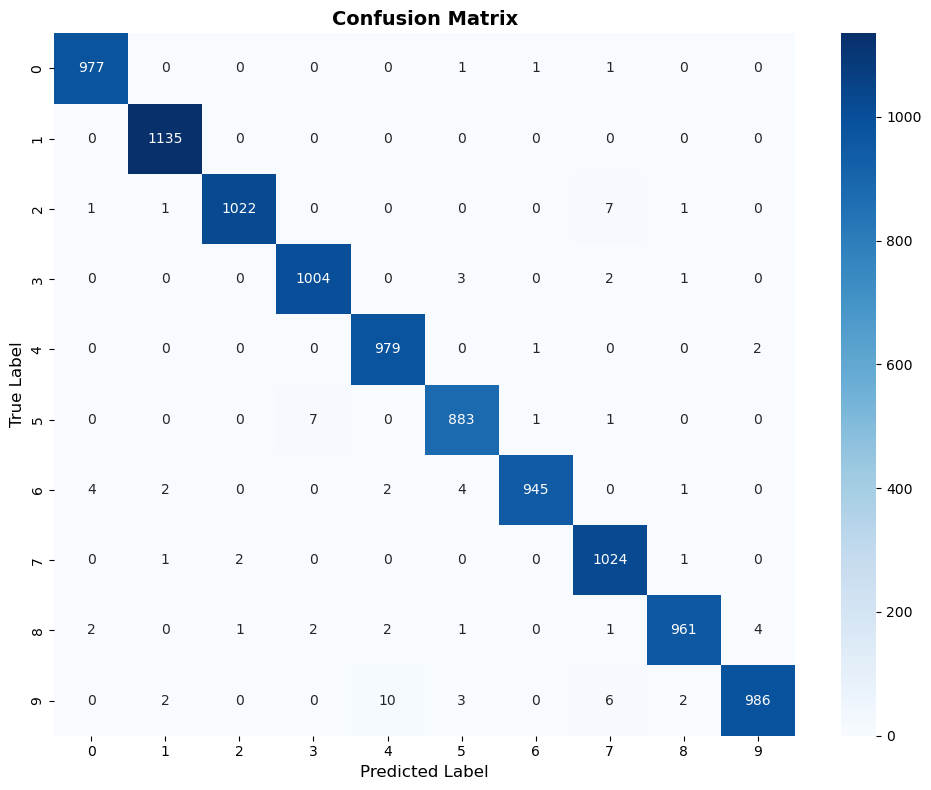


每個Digit的分類準確率:
Digit 0: 0.9969 (99.69%)
Digit 1: 1.0000 (100.00%)
Digit 2: 0.9903 (99.03%)
Digit 3: 0.9941 (99.41%)
Digit 4: 0.9969 (99.69%)
Digit 5: 0.9899 (98.99%)
Digit 6: 0.9864 (98.64%)
Digit 7: 0.9961 (99.61%)
Digit 8: 0.9867 (98.67%)
Digit 9: 0.9772 (97.72%)


In [30]:
# 計算Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# 視覺化Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.savefig(FIG_DIR / 'confusion_matrix.png')
plt.tight_layout()
plt.show()

# 計算每個類別的準確率
print("\n每個Digit的分類準確率:")
for i in range(10):
    class_accuracy = cm[i, i] / cm[i, :].sum()
    print(f"Digit {i}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

In [31]:
# 顯示分類報告
print("分類報告:\n")
report = classification_report(y_test, y_pred_classes, 
                               target_names=[f'Digit {i}' for i in range(10)])
print(report)

分類報告:

              precision    recall  f1-score   support

     Digit 0       0.99      1.00      0.99       980
     Digit 1       0.99      1.00      1.00      1135
     Digit 2       1.00      0.99      0.99      1032
     Digit 3       0.99      0.99      0.99      1010
     Digit 4       0.99      1.00      0.99       982
     Digit 5       0.99      0.99      0.99       892
     Digit 6       1.00      0.99      0.99       958
     Digit 7       0.98      1.00      0.99      1028
     Digit 8       0.99      0.99      0.99       974
     Digit 9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



---
## 13. 視覺化預測結果

Correctly Predicted SamplesCount: 9916 / 10000 (99.16%)


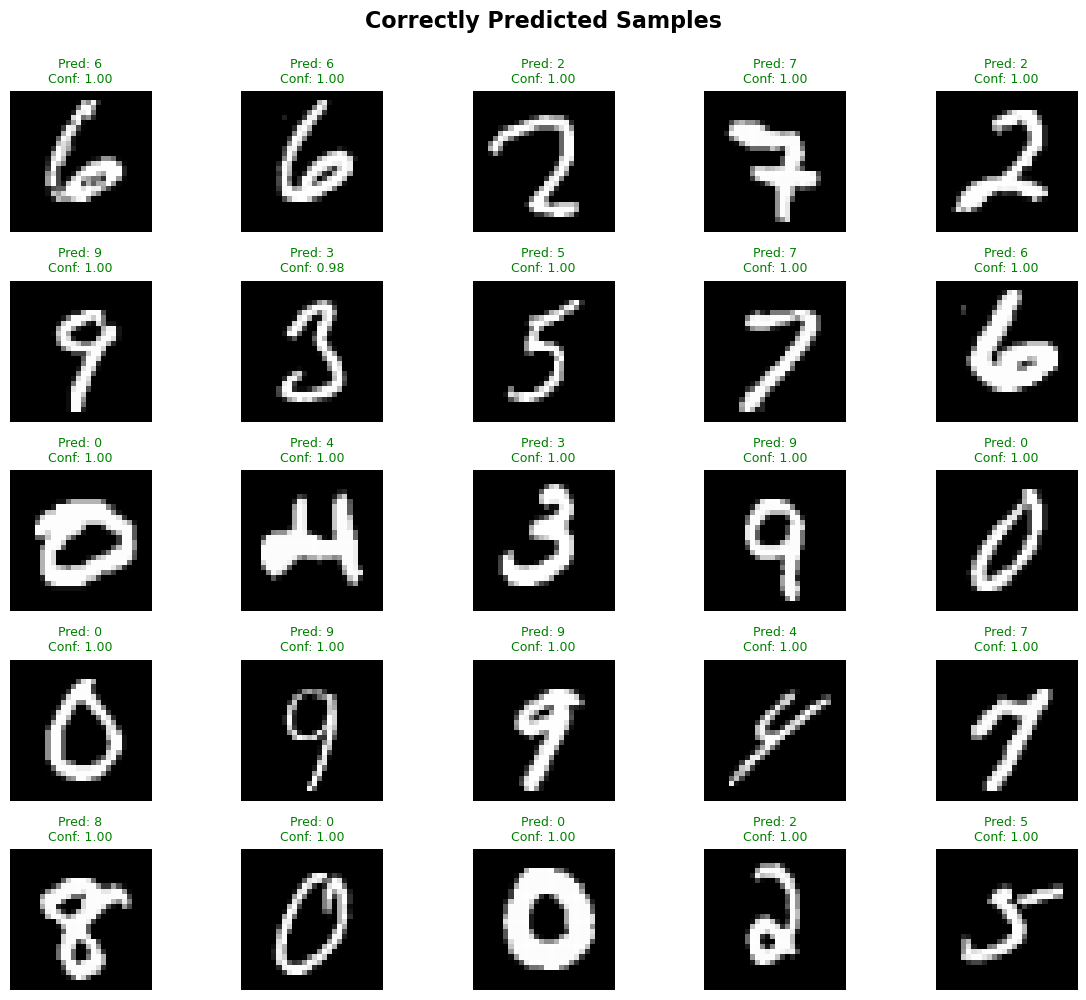

In [32]:
# 視覺化Correctly Predicted Samples
correct_indices = np.where(y_pred_classes == y_test)[0]
print(f"Correctly Predicted SamplesCount: {len(correct_indices)} / {len(y_test)} ({len(correct_indices)/len(y_test)*100:.2f}%)")

# 隨機選擇 25 個Correctly Predicted Samples
np.random.seed(42)
correct_samples = np.random.choice(correct_indices, size=25, replace=False)

plt.figure(figsize=(12, 10))
for i, idx in enumerate(correct_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[idx], cmap='gray')
    pred_class = y_pred_classes[idx]
    true_class = y_test[idx]
    confidence = y_pred_proba[idx][pred_class]
    plt.title(f'Pred: {pred_class}\nConf: {confidence:.2f}', 
              fontsize=9, color='green')
    plt.axis('off')

plt.suptitle('Correctly Predicted Samples', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(FIG_DIR / 'correctly_predicted_samples.png')
plt.show()

Incorrectly Predicted SamplesCount: 84 / 10000 (0.84%)


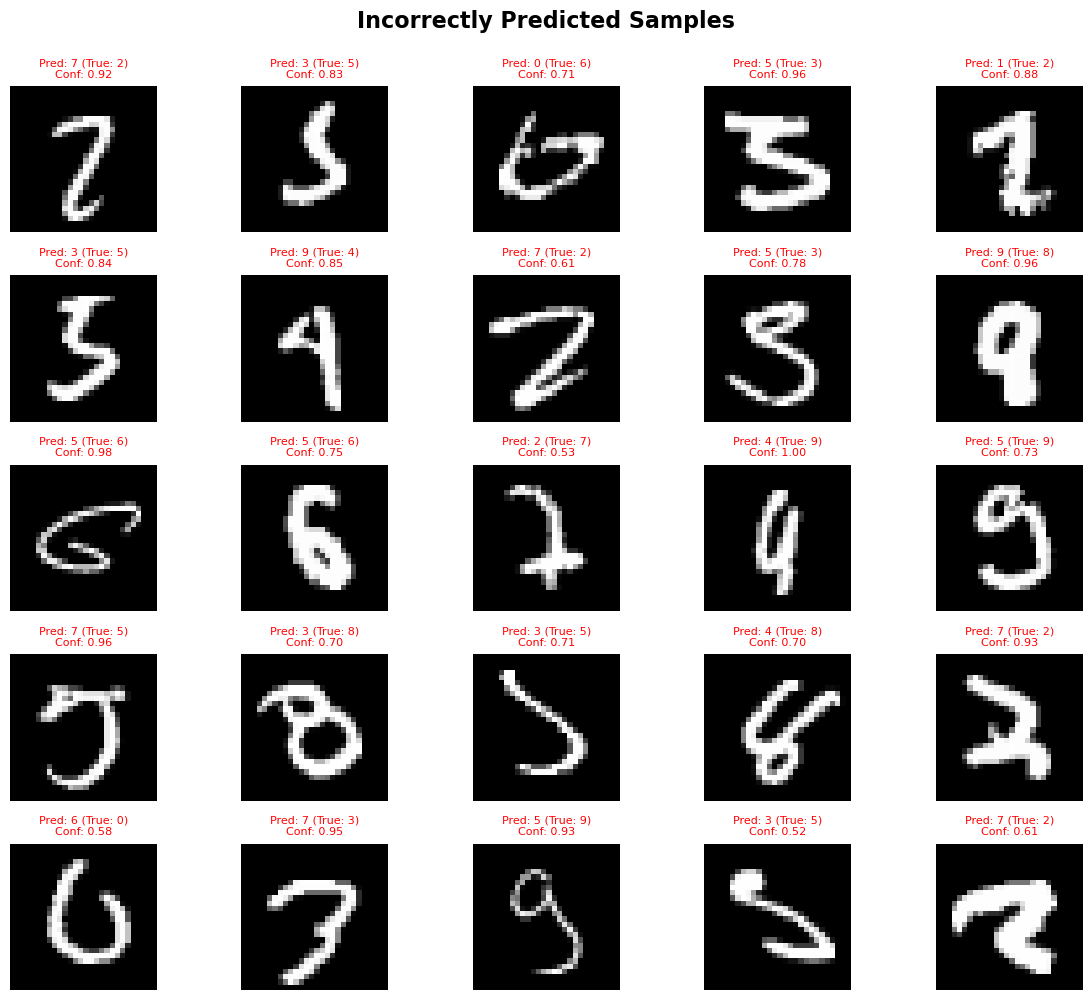

In [33]:
# 視覺化Incorrectly Predicted Samples
incorrect_indices = np.where(y_pred_classes != y_test)[0]
print(f"Incorrectly Predicted SamplesCount: {len(incorrect_indices)} / {len(y_test)} ({len(incorrect_indices)/len(y_test)*100:.2f}%)")

if len(incorrect_indices) > 0:
    # 選擇前 25 個Incorrectly Predicted Samples
    num_samples = min(25, len(incorrect_indices))
    incorrect_samples = incorrect_indices[:num_samples]
    
    plt.figure(figsize=(12, 10))
    for i, idx in enumerate(incorrect_samples):
        plt.subplot(5, 5, i + 1)
        plt.imshow(x_test[idx], cmap='gray')
        pred_class = y_pred_classes[idx]
        true_class = y_test[idx]
        confidence = y_pred_proba[idx][pred_class]
        plt.title(f'Pred: {pred_class} (True: {true_class})\nConf: {confidence:.2f}', 
                  fontsize=8, color='red')
        plt.axis('off')
    
    plt.suptitle('Incorrectly Predicted Samples', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'incorrect_samples.png')
    plt.show()
else:
    print("沒有Incorrectly Predicted Samples!")

Correctly Predicted Samples:


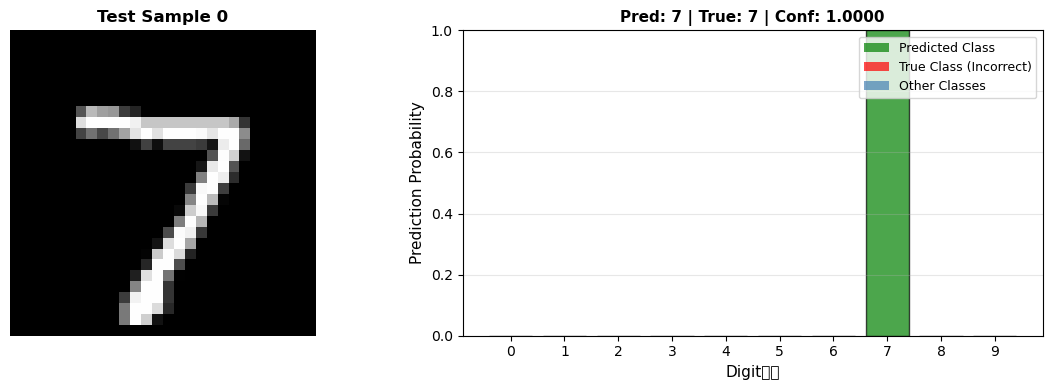


Incorrectly Predicted Samples:


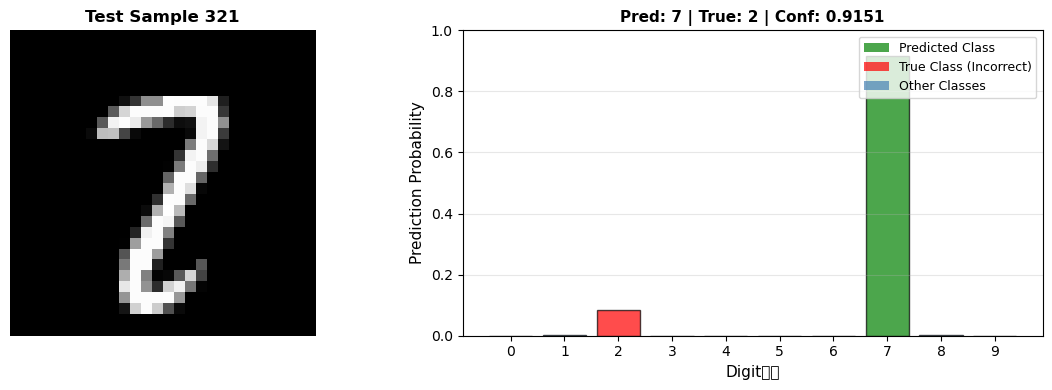

In [34]:
# 視覺化單一樣本的Prediction Probability分布
def plot_prediction_distribution(idx):
    """
    視覺化單一樣本的Prediction Probability分布
    """
    plt.figure(figsize=(12, 4))
    
    # 顯示影像
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f'Test Sample {idx}', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # 顯示Prediction Probability分布
    plt.subplot(1, 2, 2)
    pred_proba = y_pred_proba[idx]
    pred_class = y_pred_classes[idx]
    true_class = y_test[idx]
    
    colors = ['green' if i == pred_class else 'steelblue' for i in range(10)]
    if pred_class != true_class:
        colors[true_class] = 'red'
    
    bars = plt.bar(range(10), pred_proba, color=colors, alpha=0.7, edgecolor='black')
    plt.xlabel('Digit類別', fontsize=11)
    plt.ylabel('Prediction Probability', fontsize=11)
    plt.title(f'Pred: {pred_class} | True: {true_class} | Conf: {pred_proba[pred_class]:.4f}', 
              fontsize=11, fontweight='bold')
    plt.xticks(range(10))
    plt.ylim([0, 1])
    plt.grid(axis='y', alpha=0.3)
    
    # 添加圖例
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.7, label='Predicted Class'),
        Patch(facecolor='red', alpha=0.7, label='True Class (Incorrect)'),
        Patch(facecolor='steelblue', alpha=0.7, label='Other Classes')
    ]
    plt.legend(handles=legend_elements, fontsize=9, loc='upper right')
    
    plt.tight_layout()
    plt.savefig(FIG_DIR / f'plot_prediction_distribution_{idx}.png')
    plt.show()

# 視覺化幾個樣本的Prediction Probability分布
print("Correctly Predicted Samples:")
plot_prediction_distribution(correct_indices[0])

if len(incorrect_indices) > 0:
    print("\nIncorrectly Predicted Samples:")
    plot_prediction_distribution(incorrect_indices[0])

---
## 14. 模型保存與載入

### 保存模型的三種方式:
1. **保存整個模型** (架構 + 權重 + 訓練配置)
2. **只保存權重**
3. **保存架構** (JSON 格式)

In [35]:
# 方式 1: 保存整個模型 (推薦)
model.save(MODEL_DIR / 'mnist_cnn_complete_model.h5')
print("完整模型已保存為: mnist_cnn_complete_model.h5")

# 方式 2: 只保存權重
model.save_weights(MODEL_DIR / 'mnist_cnn_weights.h5')
print("模型權重已保存為: mnist_cnn_weights.h5")

# 方式 3: 保存模型架構為 JSON
model_json = model.to_json()
with open(MODEL_DIR / 'mnist_cnn_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("模型架構已保存為: mnist_cnn_architecture.json")

完整模型已保存為: mnist_cnn_complete_model.h5
模型權重已保存為: mnist_cnn_weights.h5
模型架構已保存為: mnist_cnn_architecture.json


In [36]:
# 載入完整模型
loaded_model = load_model(MODEL_DIR / 'mnist_cnn_complete_model.h5')
print("模型載入完成!")

# 驗證載入的模型
loaded_test_loss, loaded_test_accuracy = loaded_model.evaluate(x_test_reshaped, y_test, verbose=0)
print(f"\n載入模型的測試準確率: {loaded_test_accuracy:.4f}")
print(f"原始模型的測試準確率: {test_accuracy:.4f}")
print(f"\n兩者是否一致: {np.isclose(loaded_test_accuracy, test_accuracy)}")

模型載入完成!

載入模型的測試準確率: 0.9916
原始模型的測試準確率: 0.9916

兩者是否一致: True


In [37]:
# 載入架構並載入權重
from tensorflow.keras.models import model_from_json

# 載入架構
with open(MODEL_DIR / 'mnist_cnn_architecture.json', 'r') as json_file:
    loaded_model_json = json_file.read()

reconstructed_model = model_from_json(loaded_model_json)
print("模型架構載入完成!")

# 載入權重
reconstructed_model.load_weights(MODEL_DIR / 'mnist_cnn_weights.h5')
print("權重載入完成!")

# 編譯模型
reconstructed_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 驗證
reconstructed_test_loss, reconstructed_test_accuracy = reconstructed_model.evaluate(
    x_test_reshaped, y_test, verbose=0
)
print(f"\n重建模型的測試準確率: {reconstructed_test_accuracy:.4f}")

模型架構載入完成!
權重載入完成!

重建模型的測試準確率: 0.9916


---
## 15. 使用載入的模型進行預測

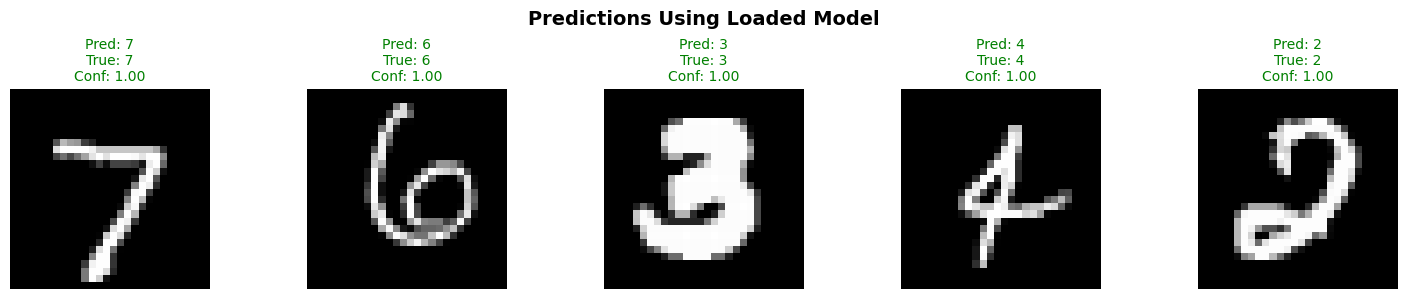

In [38]:
# 使用載入的模型進行預測
sample_indices = [0, 100, 200, 300, 400]
sample_images = x_test_reshaped[sample_indices]

# 預測
predictions = loaded_model.predict(sample_images, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)

# 視覺化
plt.figure(figsize=(15, 3))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test[idx], cmap='gray')
    pred_class = predicted_classes[i]
    true_class = y_test[idx]
    confidence = predictions[i][pred_class]
    
    color = 'green' if pred_class == true_class else 'red'
    plt.title(f'Pred: {pred_class}\nTrue: {true_class}\nConf: {confidence:.2f}', 
              fontsize=10, color=color)
    plt.axis('off')

plt.suptitle('Predictions Using Loaded Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 16. 總結

### 本次實作完成的內容:

1. ✅ **資料載入與探索**: 載入 MNIST 資料集並進行視覺化分析
2. ✅ **資料預處理**: 正規化和重塑資料以符合 CNN 輸入要求
3. ✅ **模型建立**: 使用 Keras Sequential API 建立 CNN 模型
4. ✅ **模型編譯**: 配置優化器、損失函數和評估指標
5. ✅ **模型訓練**: 使用 callbacks 控制訓練過程
6. ✅ **訓練視覺化**: 繪製訓練歷史曲線
7. ✅ **模型評估**: 在測試集上評估模型性能
8. ✅ **模型預測**: 對新數據進行預測並視覺化結果
9. ✅ **詳細評估**: 使用混淆矩陣和分類報告進行深入分析
10. ✅ **模型保存與載入**: 學習三種保存模型的方式

### 模型性能:
- 測試集準確率: **>98%** (典型結果)
- 訓練時間: 約 2-5 分鐘 (取決於硬體)

### 關鍵學習點:
1. CNN 透過卷積層自動學習影像特徵
2. 池化層降低維度並提高模型的平移不變性
3. Dropout 和 Early Stopping 有效防止過擬合
4. 訓練曲線可以幫助診斷模型性能
5. 混淆矩陣提供詳細的分類性能分析

### 下一步建議:
- 嘗試調整模型架構 (增加/減少層數、改變濾波器數量)
- 嘗試不同的優化器和學習率
- 使用數據增強 (Data Augmentation) 提高模型泛化能力
- 嘗試其他 CNN 架構 (如 VGG、ResNet)
- 應用到其他影像分類問題

---

**恭喜你完成 CNN 實作演練!** 🎉